In [1]:
try:
    output_filepath
except:
    output_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/processed/'

In [2]:
import os
from pathlib import Path

import pandas as pd
import numpy as np

import patsy
import statsmodels.api as sm
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from linearmodels.panel import BetweenOLS, PooledOLS, compare

from linearmodels import IV2SLS

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})


In [3]:
data_path = os.path.join(output_filepath, 'panel_data.parquet')
df_model = pd.read_parquet(data_path)

df_model = df_model[df_model.year.between(2001, 2016)]


centralities = ['hubs', 'authorities','pagerank', 'gfi', 'bridging', 'favor']
networks = ['financial', 'goods', 'human']
#networks = ['financial', 'goods', 'estimated_human']

df_model['human_authorities_cero'] = np.isclose(df_model.human_authorities, 0)
df_model['receiving_cuntries'] = df_model.groupby('country').human_authorities_cero.transform(lambda x: sum(x)<len(x))

#df_model = df_model[df_model.receiving_cuntries]

for c in [f'{n}_{c}' for c in centralities for n in networks]:
    df_model[c] = df_model[c].map(lambda x: np.log1p(x*1.e8))

df_model.loc[df_model.human_authorities_cero, 'human_authorities'] = np.nan
df_model['human_authorities'] = df_model['human_authorities'].fillna(df_model.groupby('year')['human_authorities'].transform(lambda x: x.median()))

df_model = df_model[~df_model.country.isin(['MNE', 'SRB', 'STP', 'PRK'])]

In [4]:
corr_cols = ['log_output', 'log_gdp', 'gini', 'log_GFCF', 'log_wkn_population'] + [f'{n}_{c}' for c in centralities for n in networks]

df_model[['country', 'year'] + corr_cols].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,2667,167,TCD,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,2667,NaN,NaN,NaN,2008.49,4.60839,2001,2004,2008,2012,2016
log_output,2667,NaN,NaN,NaN,17.9735,2.21705,10.8685,16.4284,17.7304,19.666,24.1941
log_gdp,2667,NaN,NaN,NaN,17.209,2.30451,7.3328,15.6967,16.9901,18.9457,23.5039
gini,359,NaN,NaN,NaN,0.319203,0.0594887,0.234,0.2695,0.315,0.348,0.62
log_GFCF,2479,NaN,NaN,NaN,22.9087,2.59372,0,21.4781,22.773,24.5678,29.1997
log_wkn_population,2667,NaN,NaN,NaN,15.1666,1.68387,10.7696,14.1536,15.1948,16.2155,20.4811
financial_hubs,2667,NaN,NaN,NaN,12.8975,0.712749,10.2929,12.3969,12.8522,13.3821,15.8608
goods_hubs,2667,NaN,NaN,NaN,12.1532,1.20296,8.97596,11.3941,12.1147,12.973,17.0341
human_hubs,2667,NaN,NaN,NaN,11.9124,1.54539,6.6719,10.9209,11.8337,12.8412,17.2113


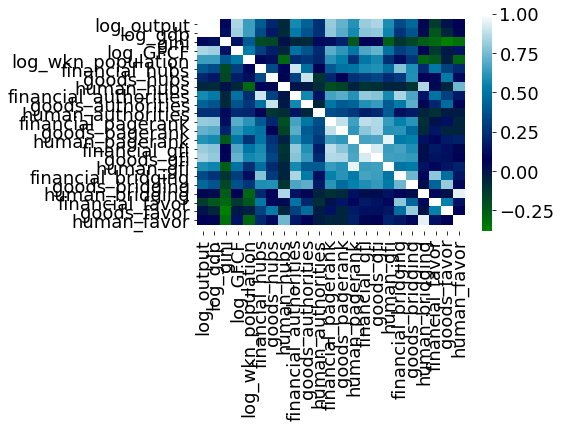

In [5]:
plt.rcParams.update({'font.size': 18})

corr = df_model[corr_cols].corr()

# plot the heatmap
sns.heatmap(corr, cmap="ocean",
        xticklabels=corr.columns,
        yticklabels=corr.columns,)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.7 # Add 0.5 to the bottom
t -= 0.7 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

## Variable selection
Some of the social capital variables we want to include are highly correlated --> need to reduce dimensionality in order to avoid multicolinearity


In [6]:
all_terms_list = [f'{n}_{c}' for c in centralities for n in networks]

In [7]:
from scipy.stats import pearsonr
import statsmodels.api as sm

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    plt.rcParams.update({'font.size': 15})

    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.5, .1), xycoords=ax.transAxes)

def r2func(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    plt.rcParams.update({'font.size': 15})

    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    results = model.fit()
    r2 = results.rsquared

    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    ax.annotate(f'$R^2$= {r2:.2f}', xy=(.5, .1), xycoords=ax.transAxes)



In [8]:
df_model[corr_cols].isnull().mean()

log_output               0.000000
log_gdp                  0.000000
gini                     0.865392
log_GFCF                 0.070491
log_wkn_population       0.000000
financial_hubs           0.000000
goods_hubs               0.000000
human_hubs               0.000000
financial_authorities    0.000000
goods_authorities        0.000000
human_authorities        0.000000
financial_pagerank       0.000000
goods_pagerank           0.000000
human_pagerank           0.000000
financial_gfi            0.000000
goods_gfi                0.000000
human_gfi                0.000000
financial_bridging       0.000000
goods_bridging           0.000000
human_bridging           0.000000
financial_favor          0.000000
goods_favor              0.000000
human_favor              0.000000
dtype: float64

In [9]:
df_model[df_model.estimated_human_favor.isnull()]

,country,year,gini,wkn_population,log_wkn_population,lag_log_wkn_population,delta_log_wkn_population,financial_hubs,financial_authorities,financial_pagerank,...,per_change_log_gdp,lag_log2_output,lag_log2_gdp,GFCF,log_GFCF,lag_log_GFCF,delta_log_GFCF,constant,human_authorities_cero,receiving_cuntries


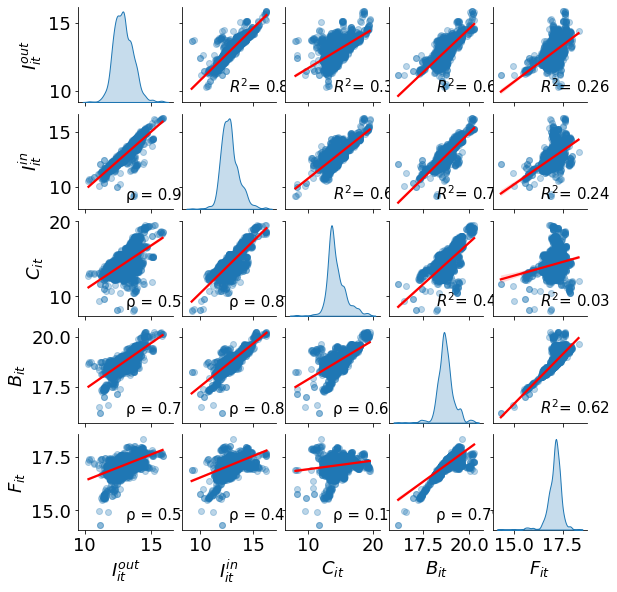

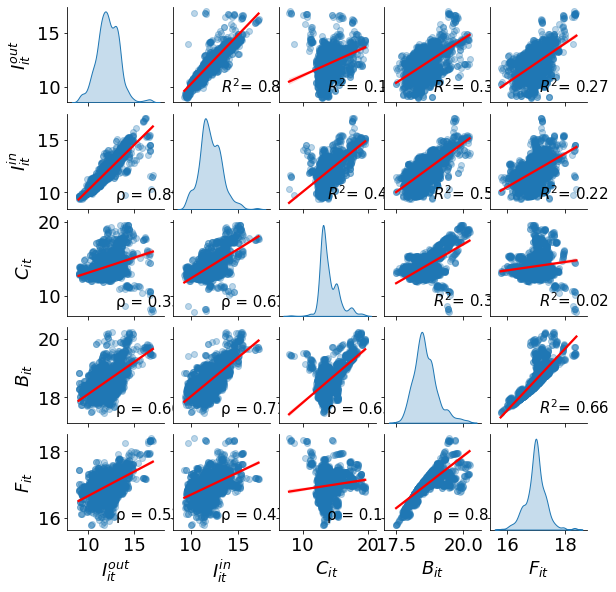

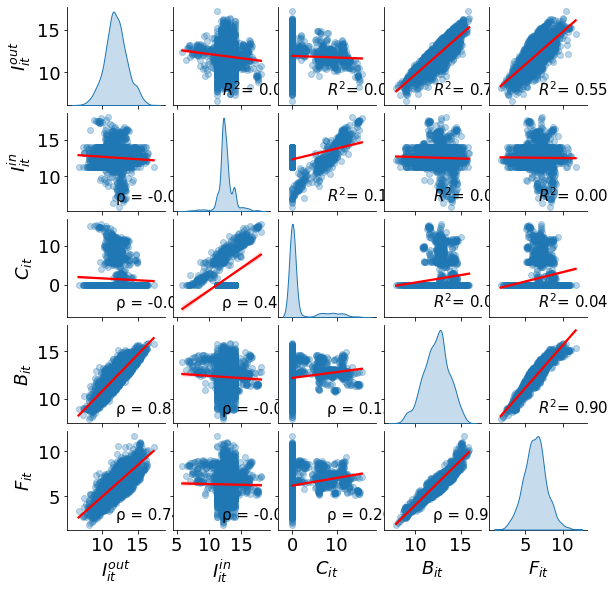

In [10]:
for n in networks:
    corr_cols = [f'{n}_{c}' for c in ['hubs', 'authorities', 'gfi', 'bridging', 'favor']] 

    plt.rcParams.update({'font.size': 18})

    g = sns.pairplot(df_model[corr_cols], kind='reg', diag_kind = 'kde', plot_kws={'scatter_kws': {'alpha': 0.3}, 'line_kws':{'color':'red'}})
    g.fig.set_size_inches(8,8)
    g.map_lower(corrfunc)
    g.map_upper(r2func)

    names = dict(zip(corr_cols, ['$I_{it}^{out}$', '$I_{it}^{in}$', '$C_{it}$', '$B_{it}$', '$F_{it}$'] ))

    plt.rcParams.update({'font.size': 18})
    for i in range(len(corr_cols)):
        for j in range(len(corr_cols)):
            xlabel = g.axes[i][j].get_xlabel()
            ylabel = g.axes[i][j].get_ylabel()
            if xlabel in names.keys():
                g.axes[i][j].set_xlabel(names[xlabel])
            if ylabel in names.keys():
                g.axes[i][j].set_ylabel(names[ylabel])

    save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'{n}_social_capital_multicolinearity.png')
    plt.savefig(save_to)    
    plt.show()

## Simultaneous model capital and migration

In [11]:
all_terms_regression = ' + '.join(all_terms_list)

In [12]:
df_model[all_terms_list].isnull().mean()

financial_hubs           0.0
goods_hubs               0.0
human_hubs               0.0
financial_authorities    0.0
goods_authorities        0.0
human_authorities        0.0
financial_pagerank       0.0
goods_pagerank           0.0
human_pagerank           0.0
financial_gfi            0.0
goods_gfi                0.0
human_gfi                0.0
financial_bridging       0.0
goods_bridging           0.0
human_bridging           0.0
financial_favor          0.0
goods_favor              0.0
human_favor              0.0
dtype: float64

In [13]:
f = f'log_gdp ~ {all_terms_regression} + log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')

model = RandomEffects(y,X)

be_res = BetweenOLS(y,X)
be_res = be_res.fit()

model = PooledOLS(y,X)
pooled_res = model.fit()

model = RandomEffects(y,X)
re_res = model.fit()

compare({'BE':be_res,'RE':re_res,'Pooled':pooled_res})

/home/ubuntu/.local/lib/python3.7/site-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


,BE,RE,Pooled
Dep. Variable,log_gdp,log_gdp,log_gdp
Estimator,BetweenOLS,RandomEffects,PooledOLS
No. Observations,161,2479,2479
Cov. Est.,Unadjusted,Unadjusted,Unadjusted
R-squared,0.9361,0.7602,0.9050
R-Squared (Within),-0.3130,0.7440,0.4776
R-Squared (Between),0.9361,0.7921,0.9262
R-Squared (Overall),0.8686,0.7852,0.9050
F-statistic,102.53,389.56,1170.7
P-value (F-stat),0.0000,0.0000,0.0000


## Stacked results

In [14]:
def stacked_results(y_label, centralities, estimator = RandomEffects):

    X_terms_list =  [f'{n}_{c}' for c in centralities for n in networks]
    all_terms_regression = ' + '.join(X_terms_list)
    f = f'{y_label} ~ {all_terms_regression} + log_GFCF + log_wkn_population + 1'
    y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
    model = estimator(y,X)
    results_combined_model = model.fit()

    df_results = pd.DataFrame(results_combined_model.params).reset_index()
    df_results['pvalues'] = results_combined_model.pvalues.values
    df_results['show_value'] = df_results.apply(lambda x: f'{round(x.parameter,4)} ({round(x.pvalues, 5)})', axis=1)
    df_results = df_results[~df_results['index'].isin(['Intercept','log_GFCF','log_wkn_population'])]
    df_results['network'], df_results['capital'] = zip(*df_results['index'].map(lambda x: (x.split('_')[-2], x.split('_')[-1])))
    print(f'''Results regression analysis: {y_label} ''')
    df_results = df_results.pivot_table(index='network', columns = 'capital', values = 'show_value', aggfunc=lambda x: x)
    
    return df_results

In [15]:
reduced_centralities = ['hubs', 'authorities', 'favor']
stacked_results('log_gdp', reduced_centralities)

Results regression analysis: log_gdp 


capital,authorities,favor,hubs
network,,,
financial,0.4227 (0.0),-1.1961 (0.0),-0.3365 (0.0)
goods,-0.0168 (0.6523),0.277 (0.00097),-0.0148 (0.62717)
human,0.1637 (0.0),0.2995 (0.0),-0.0047 (0.67879)


In [16]:
stacked_results('gini', reduced_centralities)

Results regression analysis: gini 


/home/ubuntu/.local/lib/python3.7/site-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


capital,authorities,favor,hubs
network,,,
financial,-0.0085 (0.61851),0.0553 (0.04591),0.0019 (0.91369)
goods,-0.0044 (0.32034),-0.0584 (0.01952),0.0041 (0.28097)
human,-0.0011 (0.18961),-0.0065 (0.0144),0.0044 (0.00264)


## MODEL COMPARISON

In [17]:
all_terms_regression = ' + '.join(all_terms_list)
reduced_terms_list = ['financial_' + c for c in reduced_centralities] + ['goods_' + c for c in reduced_centralities] + ['human_' + c for c in reduced_centralities]
reduced_terms_list = ['financial_hubs', 
                      'financial_authorities', 
                      'goods_hubs', 
                      'goods_authorities', 
                      #'human_hubs', 
                      #'human_authorities',
                      #'human_favor'
                         ]

reduced_terms_regression = ' + '.join(reduced_terms_list)


In [18]:
f = f'log_gdp ~ log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
base_model = RandomEffects(y,X)
base_model = base_model.fit()

f = f'log_gdp ~ {all_terms_regression} + log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
full_model = RandomEffects(y,X)
full_model = full_model.fit()

f = f'log_gdp ~ {reduced_terms_regression} + log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
reduced_model = RandomEffects(y,X)
reduced_model = reduced_model.fit()

c = compare({'Base Model':base_model,
             #'Full Model':full_model, 
             'Reduced Model':reduced_model}, precision='pvalues')
#print(c.summary.as_latex())
c.summary

/home/ubuntu/.local/lib/python3.7/site-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


,Base Model,Reduced Model
Dep. Variable,log_gdp,log_gdp
Estimator,RandomEffects,RandomEffects
No. Observations,2479,2479
Cov. Est.,Unadjusted,Unadjusted
R-squared,0.4528,0.5381
R-Squared (Within),0.4184,0.5341
R-Squared (Between),0.5441,0.4810
R-Squared (Overall),0.5268,0.4740
F-statistic,1024.6,480.06
P-value (F-stat),0.0000,0.0000


## VIF

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(df_model[reduced_terms_list].values, i) for i in range(len(reduced_terms_list))]

print(vif)

[2609.7351748340106, 3126.875163997195, 1106.3183854155006, 1581.224243205319]


## PCA variables

Text(0, 0.5, 'cumulative explained variance')

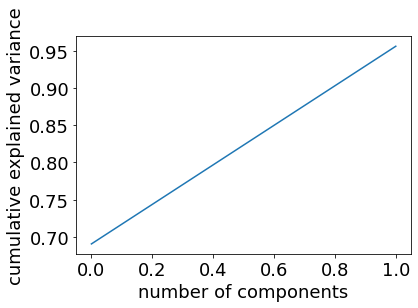

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

n = 2

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n))]
        )

all_terms = [[n + '_' + c for c in centralities] for n in networks]
all_terms = [item for sublist in all_terms for item in sublist]
all_terms = reduced_terms_list.copy()
df_model[[f'pca_{i}' for i in range(n)]] = pipe.fit_transform(df_model[all_terms])

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n))]
        )
pipe.fit(df_model[all_terms])

plt.plot(np.cumsum(pipe['reduce_dims'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [21]:
f = 'log_gdp ~ log_GFCF + log_wkn_population + 1 + ' + ' + '.join([f'pca_{i}' for i in range(n)])
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')

model = RandomEffects(y,X)
results = model.fit()
results.summary

/home/ubuntu/.local/lib/python3.7/site-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


Dep. Variable:,log_gdp,R-squared:,0.4854
Estimator:,RandomEffects,R-squared (Between):,0.4719
No. Observations:,2479,R-squared (Within):,0.4714
Date:,"Mon, Aug 23 2021",R-squared (Overall):,0.4608
Time:,11:17:17,Log-likelihood,-1413.4
Cov. Estimator:,Unadjusted,,
,,F-statistic:,583.41
Entities:,167,P-value,0.0000
Avg Obs:,14.844,Distribution:,"F(4,2474)"
Min Obs:,0.0000,,
Max Obs:,16.000,F-statistic (robust):,551.63


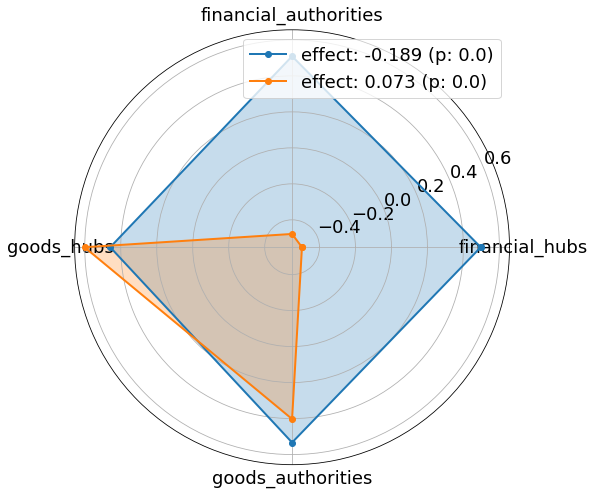

In [22]:
df_radar = pd.DataFrame(pipe['reduce_dims'].components_, columns = all_terms)
df_radar.loc[:,'coefs'] = pd.Series(results.params[[f'pca_{i}' for i in range(n)]].values)
df_radar['pvalues'] = pd.Series(results.pvalues[[f'pca_{i}' for i in range(n)]].values)

labels = all_terms.copy()
stats = pipe['reduce_dims'].components_[0]

angles=np.linspace(0, 2*np.pi, len(all_terms), endpoint=False)

fig=plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, polar=True)

for i in range(n):
    stats = df_radar.loc[i,all_terms]
    c = round(df_radar.loc[i,'coefs'], 3)
    p =  round(df_radar.loc[i,'pvalues'], 3)
    ax.plot(np.concatenate((angles,[angles[0]])), np.concatenate((stats,[stats[0]])), 
            'o-', 
            linewidth=2, 
            label = f'effect: {c} (p: {p})'
)
    ax.fill(angles, stats, alpha=0.25)
plt.legend()
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.grid(True)

## Time series

In [23]:
lagged_all_terms_list = ['delta_financial_' + c for c in reduced_centralities] + ['delta_human_' + c for c in reduced_centralities]
lagged_all_terms_list = ' + '.join(lagged_all_terms_list)

In [24]:
model = IV2SLS(df_model.delta_log_output, df_model[['financial_' + c for c in reduced_centralities] + ['human_' + c for c in reduced_centralities] + ['constant']], df_model.lag_log_output, df_model.lag_log2_output)
results = model.fit()
results.summary

/home/ubuntu/.local/lib/python3.7/site-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):
/home/ubuntu/.local/lib/python3.7/site-packages/linearmodels/utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:       delta_log_output   R-squared:                      0.0923
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0897
No. Observations:                2500   F-statistic:                    185.71
Date:                Mon, Aug 23 2021   P-value (F-stat)                0.0000
Time:                        11:17:18   Distribution:                  chi2(7)
Cov. Estimator:                robust                                         
                                                                              
                                   Parameter Estimates                                   
=========================================================================================
                       Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------
financial_hubs           -0.0806     0.0397    -2.0307     0.0423     -0.1584     -0.0028
financial_authorities     0.1119     0.0446     2.5102     0.0121      0.0245      0.1993
financial_favor          -0.1035     0.0353    -2.9356     0.0033     -0.1727     -0.0344
human_hubs                0.0049     0.0028     1.7347     0.0828     -0.0006      0.0104
human_authorities        -0.0148     0.0024    -6.2126     0.0000     -0.0194     -0.0101
human_favor              -0.0063     0.0038    -1.6783     0.0933     -0.0138      0.0011
constant                  2.0098     0.5763     3.4871     0.0005      0.8801      3.1394
lag_log_output           -0.0212     0.0057    -3.7316     0.0002     -0.0324     -0.0101
=========================================================================================

Endogenous: lag_log_output
Instruments: lag_log2_output
Robust Covariance (Heteroskedastic)
Debiased: False
"""

In [25]:
print(results.summary.as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}         & delta\_log\_output & \textbf{  R-squared:         } &      0.0923      \\
\textbf{Estimator:}             &      IV-2SLS       & \textbf{  Adj. R-squared:    } &      0.0897      \\
\textbf{No. Observations:}      &        2500        & \textbf{  F-statistic:       } &      185.71      \\
\textbf{Date:}                  &  Mon, Aug 23 2021  & \textbf{  P-value (F-stat)   } &      0.0000      \\
\textbf{Time:}                  &      11:17:18      & \textbf{  Distribution:      } &     chi2(7)      \\
\textbf{Cov. Estimator:}        &       robust       & \textbf{                     } &                  \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                                & \textbf{Parameter} & \textbf{Std. Err.} & \textbf{T-stat} & \textbf{P-value} & \textbf{Lower CI} & \textbf{Upper CI}  \\
\midrule
\textbf{financial\_hubs}        &      -0.0806       &       0.0397       &     -2.0307    